# Hospital dataset data exploration using PySpark

## Imports

In [35]:
import os
import sys

sys.path.append('..')

from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt
import seaborn as sns

from src.cleanse_data import clean_columns_names
from src.kaggle_data import download_and_move_data, prepare_hospital_data

## Load data

In [4]:

# Tell Spark to use the exact same python executable as your current environment
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["PYSPARK_GATEWAY_SECRET"] = "1"

spark = (
    SparkSession.builder.appName("DebugHospital")
    .master("local[1]")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true")
    .config("spark.python.worker.reuse", "false")
    .getOrCreate()
)

download_and_move_data()
path_hospital = prepare_hospital_data()
sdf = spark.read.csv(path_hospital, header=True, inferSchema=True)

Created directory: data
Copied hospital-dataset.xlsx to data/

✅ Dataset ready in project folder.
--- Converting data/hospital-dataset.xlsx to CSV for Spark optimization ---
--- Success: data/hospital-dataset.csv created ---


## Clean & Explore

### Retrieve schema

In [5]:
sdf.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Blood Type: string (nullable = true)
 |-- Medical Condition: string (nullable = true)
 |-- Date of Admission: date (nullable = true)
 |-- Doctor: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Insurance Provider: string (nullable = true)
 |-- Billing Amount: double (nullable = true)
 |-- Room Number: integer (nullable = true)
 |-- Admission Type: string (nullable = true)
 |-- Discharge Date: date (nullable = true)
 |-- Medication: string (nullable = true)
 |-- Test Results: string (nullable = true)



The datatypes seem to be alright. It is noticeable however that the column names have spaces. In the next step we clean the column names for further use in pyspark

### Rename columns for spark usage

clean the columns names using snakecase logic

In [7]:
sdf_cleaned = clean_columns_names(sdf)
sdf_cleaned.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- blood_type: string (nullable = true)
 |-- medical_condition: string (nullable = true)
 |-- date_of_admission: date (nullable = true)
 |-- doctor: string (nullable = true)
 |-- hospital: string (nullable = true)
 |-- insurance_provider: string (nullable = true)
 |-- billing_amount: double (nullable = true)
 |-- room_number: integer (nullable = true)
 |-- admission_type: string (nullable = true)
 |-- discharge_date: date (nullable = true)
 |-- medication: string (nullable = true)
 |-- test_results: string (nullable = true)




More details

In [9]:
count = sdf_cleaned.count()
print(f"The dataset contains {count} entries")

The dataset contains 55500 entries


### Retrieve value counts per column

Display the counts per grouping of values per column in the dataset

In [34]:
for col in sdf_cleaned.columns:
    sdf_cleaned.select(col).groupBy(col).count().show()

+----------------+-----+
|            name|count|
+----------------+-----+
| JAmES pattERson|    1|
|   SierRa MoRTON|    1|
|  JErome MorAles|    1|
|   bROokE TorreS|    1|
| mR. jaCk wIlliS|    1|
|   saNdrA MuRphy|    1|
|   DANiel brooKs|    1|
|  BoNnie bUckLey|    1|
|   lINDA kenNEDY|    1|
| ISAbeLla dAnIeL|    1|
|      aNN MIlLEr|    1|
|   anDREa RIvEra|    2|
|   KeNneth meJIa|    1|
|NicHOLAS ManniNG|    1|
|    RObeRt smiTh|    1|
|      RicK berRY|    1|
|    HEaThEr oWen|    1|
|    KAREN DUNCAn|    1|
| tAmMY heRNandez|    1|
|    RIcHArd WEst|    1|
+----------------+-----+
only showing top 20 rows

+---+-----+
|age|count|
+---+-----+
| 31|  793|
| 85|  743|
| 65|  837|
| 53|  845|
| 78|  798|
| 34|  864|
| 81|  818|
| 28|  760|
| 76|  832|
| 26|  815|
| 27|  786|
| 44|  836|
| 22|  817|
| 47|  804|
| 52|  817|
| 13|   14|
| 86|   41|
| 16|   24|
| 20|  750|
| 40|  752|
+---+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female|27726|


Notice how the count seems evenly distributed, like a uniform distribution. This seems to look like synthetic data. We will further investigate this in the next steps

Display average bill amount, volatility and amount of patients per admission type

In [14]:
billing_profile = sdf_cleaned.groupBy("admission_type") \
    .agg(
        F.round(F.avg("billing_amount"), 2).alias("avg_bill"),
        F.round(F.stddev("billing_amount"), 2).alias("price_volatility"),
        F.count("*").alias("total_patients")
    ).orderBy("avg_bill", ascending=False)

billing_profile.show()

+--------------+--------+----------------+--------------+
|admission_type|avg_bill|price_volatility|total_patients|
+--------------+--------+----------------+--------------+
|      Elective|25602.23|        14228.28|         18655|
|        Urgent|25517.36|        14242.63|         18576|
|     Emergency| 25497.4|        14163.01|         18269|
+--------------+--------+----------------+--------------+



Display average days in hospital per medical condition

In [16]:
# Calculate stay duration and find the average per medical condition
stay_analysis = sdf_cleaned.withColumn("los", F.datediff("discharge_date", "date_of_admission")) \
    .groupBy("medical_condition") \
    .agg(F.round(F.avg("los"), 1).alias("avg_days_in_hospital")) \
    .orderBy("avg_days_in_hospital", ascending=False)

stay_analysis.show()

+-----------------+--------------------+
|medical_condition|avg_days_in_hospital|
+-----------------+--------------------+
|           Asthma|                15.7|
|          Obesity|                15.5|
|        Arthritis|                15.5|
|     Hypertension|                15.5|
|           Cancer|                15.5|
|         Diabetes|                15.4|
+-----------------+--------------------+



Display claim frequency and total revenue per insurance provider

In [19]:
insurance_analysis = sdf_cleaned.groupBy("insurance_provider") \
    .agg(
        F.count("*").alias("claim_count"),
        F.round(F.sum("billing_amount"), 2).alias("total_revenue")
    ).orderBy("total_revenue", ascending=False)

insurance_analysis.show()

+------------------+-----------+--------------+
|insurance_provider|claim_count| total_revenue|
+------------------+-----------+--------------+
|             Cigna|      11249|2.8713934527E8|
|          Medicare|      11154|2.8572075813E8|
|        Blue Cross|      11059|2.8325429421E8|
|  UnitedHealthcare|      11125|2.8245454284E8|
|             Aetna|      10913|2.7886310295E8|
+------------------+-----------+--------------+



Display medication usage per medical condition

In [21]:
# What is the go-to medication for 'Asthma' or 'Diabetes'?
medication_trends = sdf_cleaned.groupBy("medical_condition", "medication") \
    .count() \
    .orderBy("medical_condition", "count", ascending=[True, False])

medication_trends.show(20)

+-----------------+-----------+-----+
|medical_condition| medication|count|
+-----------------+-----------+-----+
|        Arthritis|    Aspirin| 1918|
|        Arthritis|Paracetamol| 1877|
|        Arthritis| Penicillin| 1866|
|        Arthritis|    Lipitor| 1825|
|        Arthritis|  Ibuprofen| 1822|
|           Asthma|Paracetamol| 1888|
|           Asthma| Penicillin| 1845|
|           Asthma|  Ibuprofen| 1827|
|           Asthma|    Lipitor| 1823|
|           Asthma|    Aspirin| 1802|
|           Cancer|    Lipitor| 1922|
|           Cancer|  Ibuprofen| 1873|
|           Cancer|Paracetamol| 1853|
|           Cancer| Penicillin| 1793|
|           Cancer|    Aspirin| 1786|
|         Diabetes|    Lipitor| 1893|
|         Diabetes| Penicillin| 1881|
|         Diabetes|  Ibuprofen| 1861|
|         Diabetes|    Aspirin| 1858|
|         Diabetes|Paracetamol| 1811|
+-----------------+-----------+-----+
only showing top 20 rows



Display medical condition per gender

In [33]:
sdf_cleaned.select("gender","medical_condition").groupBy("gender","medical_condition").count().orderBy("medical_condition","gender").show()


+------+-----------------+-----+
|gender|medical_condition|count|
+------+-----------------+-----+
|Female|        Arthritis| 4686|
|  Male|        Arthritis| 4622|
|Female|           Asthma| 4553|
|  Male|           Asthma| 4632|
|Female|           Cancer| 4602|
|  Male|           Cancer| 4625|
|Female|         Diabetes| 4651|
|  Male|         Diabetes| 4653|
|Female|     Hypertension| 4612|
|  Male|     Hypertension| 4633|
|Female|          Obesity| 4622|
|  Male|          Obesity| 4609|
+------+-----------------+-----+



Display the correlation between age and the billing amount (would expect higher billing for older patients)

In [23]:
correlation = sdf_cleaned.stat.corr("age", "billing_amount")
print(f"Pearson Correlation between Age and Billing: {correlation:.4f}")

Pearson Correlation between Age and Billing: -0.0038


### Visualisation

from the above exploration it is noticeable that the amounts are very evenly distributed for each analysis.
Let's display this with some visualizations to fully confirm we have indeed uniformly distributed data which is most likely synthetic data which has been generated.

#### Histogram age and billing amount

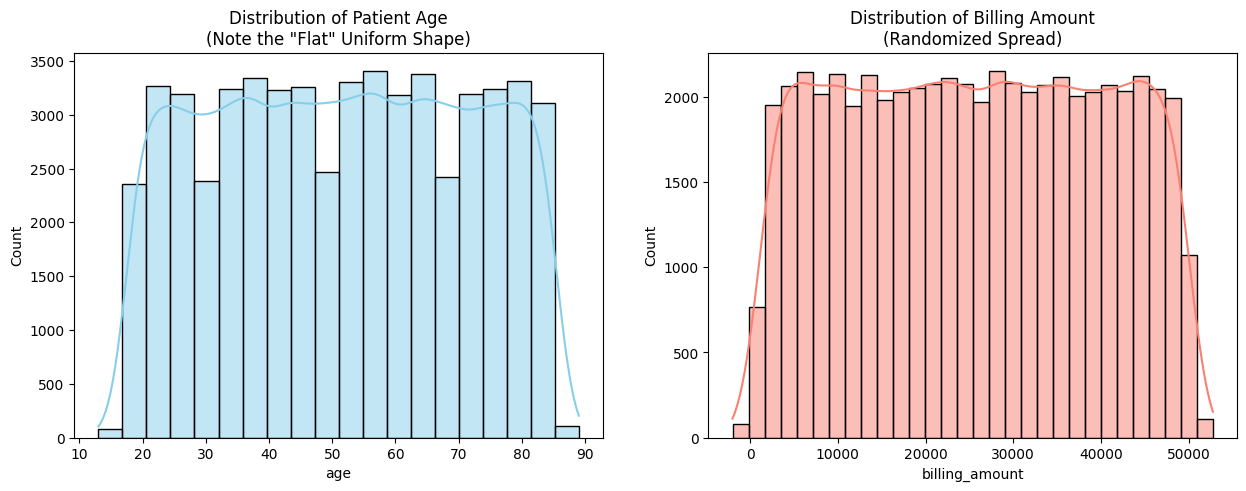

In [36]:
# Convert to Pandas for plotting (55k rows is safe for local memory)
pdf = sdf_cleaned.select("age", "billing_amount").toPandas()

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Age Distribution
sns.histplot(pdf['age'], bins=20, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of Patient Age\n(Note the "Flat" Uniform Shape)')

# Billing Distribution
sns.histplot(pdf['billing_amount'], bins=30, kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of Billing Amount\n(Randomized Spread)')

plt.show()

#### Scatter plot age and billing amount

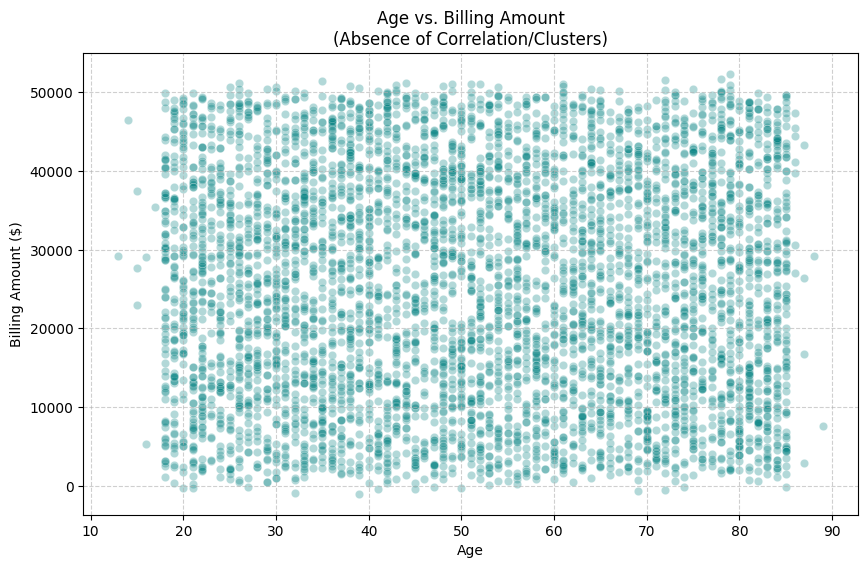

In [37]:
plt.figure(figsize=(10, 6))
# We sample 5,000 points so the plot isn't too crowded
sns.scatterplot(data=pdf.sample(5000), x='age', y='billing_amount', alpha=0.3, color='teal')

plt.title('Age vs. Billing Amount\n(Absence of Correlation/Clusters)')
plt.xlabel('Age')
plt.ylabel('Billing Amount ($)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Barplot medical condition

C:\Users\Stephen\AppData\Local\Temp\ipykernel_7692\2613040933.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=condition_counts, x='medical_condition', y='count', palette='viridis')


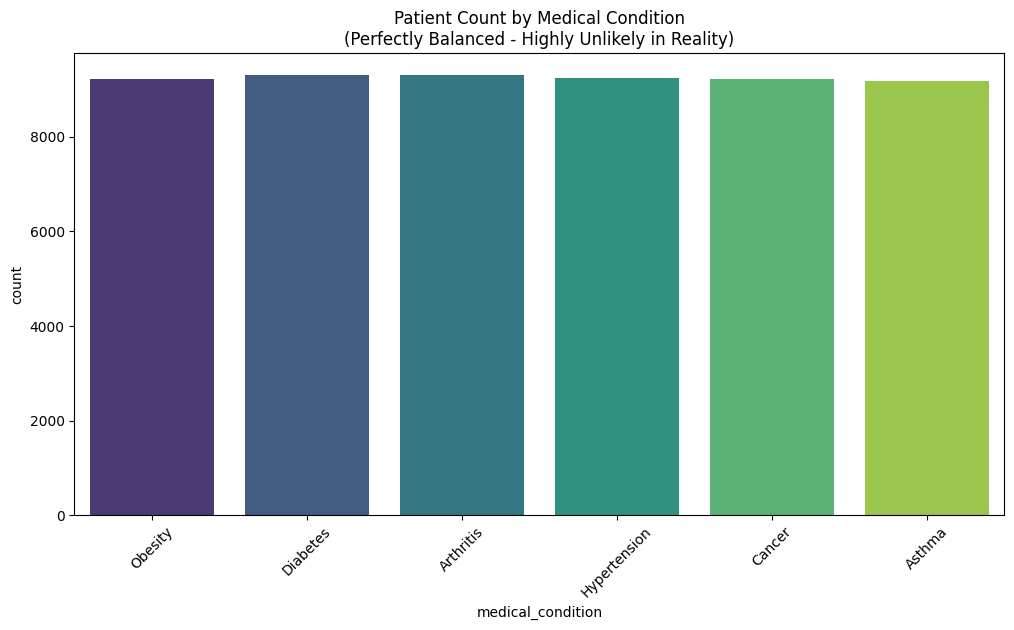

In [39]:
# Aggregate in Spark first
condition_counts = sdf_cleaned.groupBy("medical_condition").count().toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=condition_counts, x='medical_condition', y='count', palette='viridis')

plt.title('Patient Count by Medical Condition\n(Perfectly Balanced - Highly Unlikely in Reality)')
plt.xticks(rotation=45)
plt.show()

#### Heatmap admission type and test results

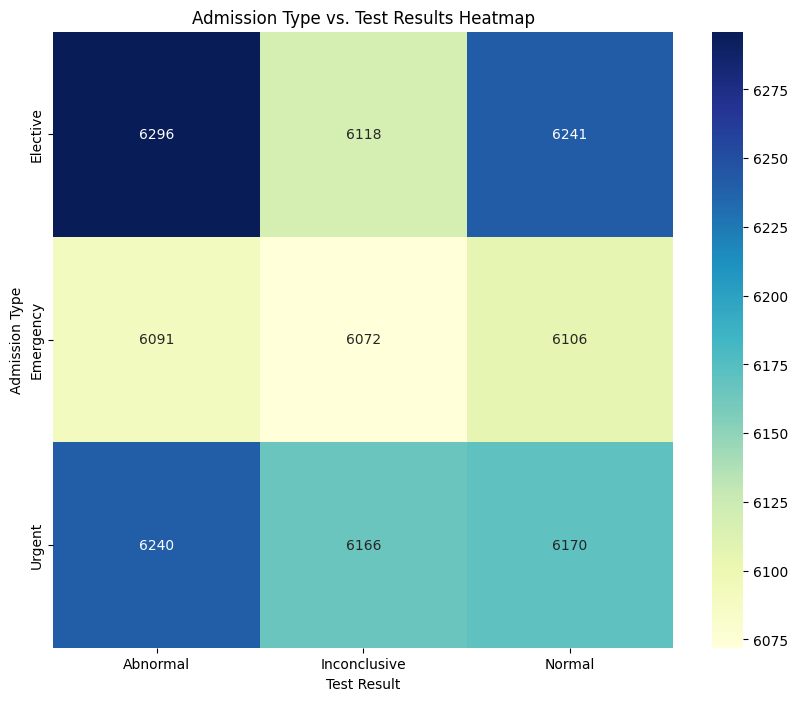

In [43]:
# Create the crosstab in Spark and convert to Pandas
ct_df = sdf_cleaned.crosstab("admission_type", "test_results").toPandas()
ct_df.set_index('admission_type_test_results', inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(ct_df, annot=True, fmt='d', cmap='YlGnBu')

plt.title('Admission Type vs. Test Results Heatmap')
plt.ylabel('Admission Type')
plt.xlabel('Test Result')
plt.show()

close pyspark session

In [46]:
spark.stop()

## Summary

Conclusion of Exploration:

Data Authenticity: The dataset exhibits a near-perfect uniform distribution across all categorical variables (Gender, Blood Type, Medical Condition).

Statistical Anomalies: The Pearson correlation between Age and Billing Amount (~0.00) confirms a lack of real-world biological or economic relationships.

Recommendation: This dataset is excellent for testing ETL pipeline scalability and PySpark transformations, but should not be used for predictive medical modeling due to its synthetic nature.